In [803]:
from catboost import CatBoostClassifier, Pool
from catboost.utils import eval_metric
from sklearn.datasets import make_multilabel_classification
from sklearn.model_selection import train_test_split
import pandas as pd
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, classification_report, precision_recall_curve
import numpy as np
import plotly.express as px
import shap
import seaborn as sns
from IPython import display
import matplotlib.pyplot as plt
import awswrangler as wr
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    multilabel_confusion_matrix,
)
from catboost.utils import select_threshold
from skmultilearn.model_selection.iterative_stratification import (
    IterativeStratification,
)
from sklearn.model_selection import StratifiedKFold, KFold
from tqdm import tqdm
from catboost.utils import get_roc_curve, select_threshold
from torchmetrics.classification import BinaryPrecisionRecallCurve
from supervised.automl import AutoML
import warnings
from loguru import logger
from sklearn.metrics import f1_score, precision_score, recall_score
from catboost.utils import eval_metric
from catboost import metrics as cat_metrics
from sklearn.utils import class_weight

warnings.filterwarnings("ignore")


In [804]:
wr.config.s3_endpoint_url = "http://192.168.1.4:8333"

multilabelDf = wr.s3.read_parquet(
    path=f"s3://multilabel_df/",
    dataset=True,
)
multilabelDf.columns

Index(['vision_bonnet', 'vision_bumper_front', 'vision_grille',
       'vision_headlamp_rh', 'vision_headlamp_lh', 'vision_door_front_lh',
       'vision_door_front_rh', 'vision_engine', 'vision_bumper_rear',
       'vision_misc', 'vision_front_panel', 'vision_non_external',
       'vision_wheel', 'vision_fender_front_lh', 'vision_fender_front_rh',
       'vision_rear_quarter_lh', 'vision_tail_lamp_lh', 'vision_tail_lamp_rh',
       'vision_windscreen_front', 'vision_rear_compartment',
       'vision_rear_panel', 'vision_rear_quarter_rh', 'vision_door_rear_rh',
       'vision_door_rear_lh', 'bonnet', 'bumper_front', 'grille',
       'fog_lamp_rh', 'headlamp_lh', 'headlamp_rh', 'door_front_lh',
       'door_front_rh', 'air_conditioning', 'cooling_fan', 'radiator',
       'bumper_rear', 'misc', 'engine', 'airbag', 'front_panel',
       'undercarriage', 'wheel', 'fender_front_lh', 'fender_front_rh',
       'door_mirror_rh', 'rear_quarter_lh', 'interior', 'tail_lamp_lh',
       'fog_lamp_l

In [805]:
# multilabelDf.replace(pd.NA, 0, inplace=True)

In [806]:
multilabelDf["Assembly_Type"]

0         3
1         3
2         3
3         3
4         3
         ..
598121    3
598122    3
598123    3
598124    2
598125    3
Name: Assembly_Type, Length: 598126, dtype: Int64

In [807]:
multilabelDf[multilabelDf["Model"] == "NA"]

,vision_bonnet,vision_bumper_front,vision_grille,vision_headlamp_rh,vision_headlamp_lh,vision_door_front_lh,vision_door_front_rh,vision_engine,vision_bumper_rear,vision_misc,...,Assembly_Type,Vehicle_Still_Driveable,NCB_Stat,Claim_Type,Vehicle_Type,Sum_Insured,Repairer,Repairer_Apprv_Count,Collision_With,Handling_Insurer


In [808]:
wr.config.s3_endpoint_url = "http://192.168.1.4:8333"

multilabelDf = wr.s3.read_parquet(
        path=f"s3://multilabel_df/",
        dataset=True,
    )
allVisionFeatures = [x for x in multilabelDf.columns if "vision_" in x]
caseFeatures = [
    "Circumstances_of_Accident",
    "Model",
    # "Vehicle_Still_Driveable",
    # "NCB_Stat",
    # "Assembly_Type",
    # "Claim_Type",
    "Vehicle_Type",
    # # "Sum_Insured",
    # "Repairer",
    # # # "Repairer_Apprv_Count",
    # "Collision_With",
    # "Handling_Insurer",
]
exclude = ['Sum_Insured', 'Repairer', 'Repairer_Apprv_Count', 
"Vehicle_Still_Driveable",
    "NCB_Stat",
    "Assembly_Type",
    "Claim_Type",
    # "Vehicle_Type",
    "Sum_Insured",
    "Repairer",
    "Repairer_Apprv_Count",
    "Collision_With",
    "Handling_Insurer"
     ]
# contFeatures = ["Sum_Insured", "Repairer_Apprv_Count"]
allInputFeature = caseFeatures + allVisionFeatures
allTargetCol = [
   'bonnet', 'bumper_front', 'grille', 'fog_lamp_rh', 'headlamp_lh', 'headlamp_rh', 'door_front_lh', 'door_front_rh', 'air_conditioning', 'cooling_fan', 'radiator', 'bumper_rear', 'misc', 'engine', 'airbag', 'front_panel', 'undercarriage', 'wheel', 'fender_front_lh', 'fender_front_rh', 'door_mirror_rh', 'rear_quarter_lh', 'interior', 'tail_lamp_lh', 'fog_lamp_lh', 'tail_lamp_rh', 'windscreen_front', 'rear_compartment', 'rear_panel', 'rear_quarter_rh', 'door_rear_rh', 'door_mirror_lh', 'door_rear_lh', 'windscreen_rear'
]
saloonPredDf = pd.read_csv(
    "/home/alextay96/Desktop/all_workspace/new_workspace/DLDataPipeline/data/results/saloon_focal_480_aug_2/Saloon - 4 Dr_imgs_pred_output.csv"
)
hatchBackDf = pd.read_csv("/home/alextay96/Desktop/all_workspace/new_workspace/DLDataPipeline/data/results/hatchback_focal_480_aug/Hatchback - 5 Dr_imgs_pred_output.csv")
suvDf = pd.read_csv("/home/alextay96/Desktop/all_workspace/new_workspace/DLDataPipeline/data/results/suv_focal_480_aug/SUV - 5 Dr_imgs_pred_output.csv")

imgPredOutput = pd.concat([saloonPredDf, hatchBackDf, suvDf])
# imgPredOutput = saloonPredDf
allPredModel = []
allPreds = []
allGt = []
realTestDataDf = multilabelDf[caseFeatures + allTargetCol + ["CaseID"]].merge(
    imgPredOutput, on="CaseID"
)
realTestDataDf = realTestDataDf.loc[
    :, ~realTestDataDf.columns.str.contains("^Unnamed")
]
trainDf = multilabelDf[
    ~multilabelDf["CaseID"].isin(realTestDataDf["CaseID"].unique().tolist())
]
# trainDf = trainDf.sample(frac=0.5)
assert set(realTestDataDf["CaseID"].tolist()).isdisjoint(trainDf["CaseID"].tolist())
targetPart = [
    "fog_lamp_rh",
    "airbag",
    "undercarriage",
    "door_mirror_rh",
    "interior",
    "fog_lamp_lh",
    "door_mirror_lh",
    "windscreen_rear",
    "air_conditioning",
    "cooling_fan",
    "radiator"
]
# targetPart = [
#      'bonnet', 'bumper_front', 'grille', 'headlamp_lh', 'headlamp_rh', 'door_front_lh', 'door_front_rh', 'bumper_rear', 'misc', 'engine', 'front_panel', 'wheel', 'fender_front_lh', 'fender_front_rh', 'rear_quarter_lh', 'interior', 'tail_lamp_lh', 'tail_lamp_rh', 'windscreen_front', 'rear_compartment', 'rear_panel', 'rear_quarter_rh', 'door_rear_rh', 'door_rear_lh'
# ]
targetCol = list(set(targetPart) & set(allTargetCol))
# targetCol = allTargetCol
print(len(trainDf))
print(targetCol)

568126
['fog_lamp_lh', 'undercarriage', 'windscreen_rear', 'fog_lamp_rh', 'interior', 'door_mirror_lh', 'door_mirror_rh', 'cooling_fan', 'air_conditioning', 'radiator', 'airbag']


In [809]:
partFPThreshold = {
    # "bumper_front" : 0.3,
    # "headlamp_lh" : 0.3,
    # "headlamp_rh" : 0.3,
    # "bumper_rear":0.3,
    # "misc":0.3,
    # "engine":0.3,
     "cooling_fan" : 0.3,
    "radiator" : 0.3,
    "air_conditioning" : 0.3

}
partFNThreshold = {
    "windscreen_front" : 0.4,
    "windscreen_rear" : 0.4,
    "door_rear_lh" : 0.4,
    "door_rear_rh" : 0.4,
    "door_mirror_lh" : 0.4,
    "door_mirror_rh" : 0.4,
    "door_mirror_rh" : 0.4,
    "rear_quarter_lh" : 0.4,
    "rear_quarter_rh" : 0.4,


}
noClassWeightPart=  [
    "cooling_fan",
    "radiator",
    "air_conditioning"
]

In [810]:

for part in tqdm(targetCol):
    logger.success(f"Start training for part : {part}")
    allCaseIdByPart = []
    allPredByPart = []
    allGtByPart = []
    trainCaseId = trainDf["CaseID"].tolist()
    tempTestDataDf = realTestDataDf
    # tempTestDataDf = realTestDataDf.groupby(part).head(5000)
    testCaseId = tempTestDataDf["CaseID"].tolist()
    # sampledDf = trainDf[allInputFeature + [part]].groupby(part).sample(frac=0.3)
    X_train = trainDf[allInputFeature]
    Y_train = trainDf[part].to_frame()
   
    X_test = tempTestDataDf[allInputFeature]
    Y_test = tempTestDataDf[part].to_frame()

    pos_count = len(Y_test[Y_test[part] == 1]) / len(Y_test)
    neg_count = len(Y_test[Y_test[part] == 0]) / len(Y_test)
    pos_weight = neg_count / pos_count
    train_pool = Pool(
        X_train, Y_train, cat_features=caseFeatures + allVisionFeatures
    )
    test_pool = Pool(X_test, Y_test, cat_features=caseFeatures + allVisionFeatures)
    clsWeight=class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(Y_train.values),y=Y_train.values.squeeze(1))
    logger.success(f"train_class_weight : {clsWeight}")

    testClsWeights = {
        0 : clsWeight[0],
                1 : clsWeight[1]

    }
    print(testClsWeights)
    sampleWeights = class_weight.compute_sample_weight(class_weight=testClsWeights, y=Y_test.values)
    print(f"Shape :{sampleWeights.shape}")
    # prCurve = MulticlassPrecisionRecallCurve(num_classes=2, thresholds=11)
    clf = CatBoostClassifier(
            loss_function="Logloss",
            eval_metric="F1",
            # iterations=200,
            early_stopping_rounds=300,
            task_type="GPU",
            class_weights= clsWeight,
            # auto_class_weights="SqrtBalanced",
            use_best_model=True,
            # scale_pos_weight=20
            # class_names=["not_dmg", "dmg"],
        )
    clf.fit(train_pool, eval_set=test_pool, metric_period=100, plot=False, verbose=1)
    test_predict = clf.predict(test_pool)
    # if (part in partFPThreshold):
    #     logger.success(f"Trade off false positive : {part}")
    #     (fpr, tpr, thresholds) = get_roc_curve(clf, test_pool, plot=False)
    #     boundary = select_threshold(clf, curve=(fpr, tpr, thresholds), FPR=partFPThreshold[part])
    #     clf.set_probability_threshold(boundary)
    #     test_predict = clf.predict(X_test)
    # elif part in partFNThreshold:
    #     logger.success(f"Trade off false negative : {part}")
    #     (fpr, tpr, thresholds) = get_roc_curve(clf, test_pool, plot=False)
    #     boundary = select_threshold(clf, curve=(fpr, tpr, thresholds), FNR=partFNThreshold[part])
    #     clf.set_probability_threshold(boundary)
    #     test_predict = clf.predict(X_test)
    acc = accuracy_score(Y_test.values.astype(np.int64), test_predict, sample_weight=sampleWeights)
    confMat = confusion_matrix(Y_test.values.astype(np.int64), test_predict, sample_weight=sampleWeights)
    pos_count = len(Y_test[Y_test[part] == 1]) / len(Y_test)
    pos_count_abs = len(Y_test[Y_test[part] == 1])
    # catboostF1 = cat_metrics.F1(Y_test.values.astype(np.int64), test_predict)
    tn = confMat[0][0]
    tp = confMat[1][1]
    fp = confMat[0][1]
    fn = confMat[1][0]
    totalSample = fp + fn + tp + tn
    acc = (tp + tn) / (fp + fn + tp + tn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 =  (2 * precision * recall) / (precision + recall)
    f1_weighted = f1_score(Y_test.values.astype(np.int64), test_predict, sample_weight=sampleWeights)
    # precision_weighted = precision_score(Y_test.values.astype(np.int64), test_predict, sample_weight=sampleWeights)
    # recall_weighted = recall_score(Y_test.values.astype(np.int64), test_predict, sample_weight=sampleWeights)

    logger.success(f"F1 for part : {part} = {f1}")
    logger.success(f"Weighted F1 scikit for part : {part} = {f1_weighted}")

    # assert (tp / (tp + fn)) + (fn / (tp + fn)) == (tn / (tn + fp)) + (
    #     fp / (tn + fp)
    # )

    allPredModel.append(
        {
            "part": part,
            "tp": tp / (tp + fn),
            "tn": tn / (tn + fp),
            "fp": fp / (tn + fp),
            "fn": fn / (tp + fn),
            "acc": acc,
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "pos_count": pos_count,
            "pos_count_abs": pos_count_abs,

        }
    )
    assert len(testCaseId) == len(test_predict)
    assert len(testCaseId) == len(Y_test)

    allPreds.append({"CaseID": testCaseId, part: test_predict})
    allGt.append({"CaseID": testCaseId, part: Y_test.values.squeeze(1)})


  0%|          | 0/11 [00:00<?, ?it/s]2022-12-26 19:00:39.134 | SUCCESS  | __main__:<module>:2 - Start training for part : fog_lamp_lh
2022-12-26 19:00:41.027 | SUCCESS  | __main__:<module>:25 - train_class_weight : [0.55938395 4.7098919 ]


{0: 0.5593839476658776, 1: 4.709891895476853}
Shape :(30000,)
Learning rate set to 0.041533
0:	learn: 0.8499352	test: 0.7787705	best: 0.7787705 (0)	total: 33.2ms	remaining: 33.2s
100:	learn: 0.8598180	test: 0.7852723	best: 0.7853335 (44)	total: 3.47s	remaining: 30.9s
200:	learn: 0.8612895	test: 0.7853428	best: 0.7855053 (169)	total: 6.7s	remaining: 26.6s
300:	learn: 0.8623776	test: 0.7855042	best: 0.7857987 (241)	total: 9.68s	remaining: 22.5s
400:	learn: 0.8633345	test: 0.7861664	best: 0.7864902 (363)	total: 12.7s	remaining: 19s
500:	learn: 0.8640347	test: 0.7864021	best: 0.7867111 (494)	total: 15.7s	remaining: 15.7s
600:	learn: 0.8645986	test: 0.7865494	best: 0.7868732 (590)	total: 18.8s	remaining: 12.5s
700:	learn: 0.8649771	test: 0.7863138	best: 0.7868732 (590)	total: 21.9s	remaining: 9.34s
800:	learn: 0.8653534	test: 0.7863728	best: 0.7870065 (767)	total: 25s	remaining: 6.21s
900:	learn: 0.8658672	test: 0.7868153	best: 0.7871983 (895)	total: 28.1s	remaining: 3.08s
999:	learn: 0.866

2022-12-26 19:01:13.218 | SUCCESS  | __main__:<module>:80 - F1 for part : fog_lamp_lh = 0.7873312159963379
2022-12-26 19:01:13.219 | SUCCESS  | __main__:<module>:81 - Weighted F1 scikit for part : fog_lamp_lh = 0.7873312159963417
  9%|▉         | 1/11 [00:34<05:40, 34.09s/it]2022-12-26 19:01:13.220 | SUCCESS  | __main__:<module>:2 - Start training for part : undercarriage
2022-12-26 19:01:14.856 | SUCCESS  | __main__:<module>:25 - train_class_weight : [0.63594011 2.33904516]


{0: 0.6359401095186284, 1: 2.339045156615395}
Shape :(30000,)
Learning rate set to 0.041533
0:	learn: 0.9661823	test: 0.7168129	best: 0.7168129 (0)	total: 33.2ms	remaining: 33.2s
100:	learn: 0.9667324	test: 0.7170781	best: 0.7174871 (88)	total: 3.22s	remaining: 28.6s
200:	learn: 0.9676108	test: 0.7185958	best: 0.7185958 (200)	total: 6.4s	remaining: 25.4s
300:	learn: 0.9680965	test: 0.7190854	best: 0.7191811 (281)	total: 9.44s	remaining: 21.9s
400:	learn: 0.9684212	test: 0.7193000	best: 0.7193173 (398)	total: 12.5s	remaining: 18.6s
500:	learn: 0.9686698	test: 0.7194725	best: 0.7195509 (454)	total: 15.5s	remaining: 15.5s
600:	learn: 0.9688703	test: 0.7196357	best: 0.7197314 (579)	total: 18.6s	remaining: 12.3s
700:	learn: 0.9689844	test: 0.7195399	best: 0.7197314 (579)	total: 21.6s	remaining: 9.23s
800:	learn: 0.9691065	test: 0.7195745	best: 0.7197314 (579)	total: 24.8s	remaining: 6.17s
bestTest = 0.7197313647
bestIteration = 579
Shrink model to first 580 iterations.


2022-12-26 19:01:42.909 | SUCCESS  | __main__:<module>:80 - F1 for part : undercarriage = 0.7197313743218811
2022-12-26 19:01:42.910 | SUCCESS  | __main__:<module>:81 - Weighted F1 scikit for part : undercarriage = 0.7197313743219216
 18%|█▊        | 2/11 [01:03<04:43, 31.50s/it]2022-12-26 19:01:42.911 | SUCCESS  | __main__:<module>:2 - Start training for part : windscreen_rear
2022-12-26 19:01:44.598 | SUCCESS  | __main__:<module>:25 - train_class_weight : [ 0.52175167 11.99337133]


{0: 0.5217516682248398, 1: 11.993371332066708}
Shape :(30000,)
Learning rate set to 0.041533
0:	learn: 0.9283713	test: 0.6473423	best: 0.6473423 (0)	total: 38.2ms	remaining: 38.1s
100:	learn: 0.9436199	test: 0.6508178	best: 0.6520528 (97)	total: 3.51s	remaining: 31.2s
200:	learn: 0.9458220	test: 0.6480799	best: 0.6520528 (97)	total: 6.91s	remaining: 27.5s
300:	learn: 0.9468735	test: 0.6467457	best: 0.6520528 (97)	total: 10s	remaining: 23.2s


2022-12-26 19:01:58.106 | SUCCESS  | __main__:<module>:80 - F1 for part : windscreen_rear = 0.6520528480442296
2022-12-26 19:01:58.107 | SUCCESS  | __main__:<module>:81 - Weighted F1 scikit for part : windscreen_rear = 0.6520528480442516
 27%|██▋       | 3/11 [01:18<03:12, 24.06s/it]2022-12-26 19:01:58.108 | SUCCESS  | __main__:<module>:2 - Start training for part : fog_lamp_rh


bestTest = 0.6520528495
bestIteration = 97
Shrink model to first 98 iterations.


2022-12-26 19:01:59.763 | SUCCESS  | __main__:<module>:25 - train_class_weight : [0.58195321 3.55052121]


{0: 0.5819532082274851, 1: 3.550521210909182}
Shape :(30000,)
Learning rate set to 0.041533
0:	learn: 0.8468118	test: 0.7201704	best: 0.7201704 (0)	total: 32ms	remaining: 32s
100:	learn: 0.8616487	test: 0.7271925	best: 0.7271925 (100)	total: 3.31s	remaining: 29.5s
200:	learn: 0.8639180	test: 0.7282398	best: 0.7284093 (198)	total: 6.45s	remaining: 25.6s
300:	learn: 0.8649895	test: 0.7286139	best: 0.7291957 (242)	total: 9.44s	remaining: 21.9s
400:	learn: 0.8658434	test: 0.7292172	best: 0.7293194 (388)	total: 12.4s	remaining: 18.6s
500:	learn: 0.8663123	test: 0.7287962	best: 0.7293194 (388)	total: 15.5s	remaining: 15.4s
600:	learn: 0.8667542	test: 0.7280717	best: 0.7293194 (388)	total: 18.5s	remaining: 12.3s
bestTest = 0.7293194051
bestIteration = 388
Shrink model to first 389 iterations.


2022-12-26 19:02:21.516 | SUCCESS  | __main__:<module>:80 - F1 for part : fog_lamp_rh = 0.7293194088074526
2022-12-26 19:02:21.516 | SUCCESS  | __main__:<module>:81 - Weighted F1 scikit for part : fog_lamp_rh = 0.7293194088074036
 36%|███▋      | 4/11 [01:42<02:46, 23.80s/it]2022-12-26 19:02:21.517 | SUCCESS  | __main__:<module>:2 - Start training for part : interior
2022-12-26 19:02:23.138 | SUCCESS  | __main__:<module>:25 - train_class_weight : [0.55972012 4.68619364]


{0: 0.5597201231899336, 1: 4.68619364204761}
Shape :(30000,)
Learning rate set to 0.041533
0:	learn: 0.9201648	test: 0.7202166	best: 0.7202166 (0)	total: 30.4ms	remaining: 30.3s
100:	learn: 0.9288498	test: 0.7230085	best: 0.7230519 (96)	total: 3.21s	remaining: 28.6s
200:	learn: 0.9311068	test: 0.7242343	best: 0.7250420 (160)	total: 6.31s	remaining: 25.1s
300:	learn: 0.9320073	test: 0.7255188	best: 0.7255188 (300)	total: 9.31s	remaining: 21.6s
400:	learn: 0.9325983	test: 0.7262242	best: 0.7264567 (392)	total: 12.3s	remaining: 18.4s
500:	learn: 0.9330404	test: 0.7261549	best: 0.7267102 (483)	total: 15.5s	remaining: 15.5s
600:	learn: 0.9336311	test: 0.7266731	best: 0.7269533 (598)	total: 18.7s	remaining: 12.4s
700:	learn: 0.9341800	test: 0.7263076	best: 0.7269533 (598)	total: 21.7s	remaining: 9.27s
800:	learn: 0.9345653	test: 0.7271388	best: 0.7272342 (789)	total: 24.8s	remaining: 6.15s
900:	learn: 0.9348522	test: 0.7265243	best: 0.7272342 (789)	total: 27.8s	remaining: 3.05s
999:	learn: 0

2022-12-26 19:02:54.721 | SUCCESS  | __main__:<module>:80 - F1 for part : interior = 0.7272341960599906
2022-12-26 19:02:54.722 | SUCCESS  | __main__:<module>:81 - Weighted F1 scikit for part : interior = 0.7272341960599075
 45%|████▌     | 5/11 [02:15<02:43, 27.19s/it]2022-12-26 19:02:54.723 | SUCCESS  | __main__:<module>:2 - Start training for part : door_mirror_lh
2022-12-26 19:02:56.325 | SUCCESS  | __main__:<module>:25 - train_class_weight : [0.52973208 8.90842663]


{0: 0.5297320784202566, 1: 8.908426631542635}
Shape :(30000,)
Learning rate set to 0.041533
0:	learn: 0.8809344	test: 0.7034752	best: 0.7034752 (0)	total: 35.5ms	remaining: 35.4s
100:	learn: 0.9028194	test: 0.7180010	best: 0.7182053 (98)	total: 3s	remaining: 26.7s
200:	learn: 0.9075689	test: 0.7223345	best: 0.7248443 (170)	total: 6.05s	remaining: 24.1s
300:	learn: 0.9102125	test: 0.7231382	best: 0.7248443 (170)	total: 9s	remaining: 20.9s
400:	learn: 0.9116341	test: 0.7246721	best: 0.7252636 (386)	total: 11.9s	remaining: 17.8s
500:	learn: 0.9127329	test: 0.7270585	best: 0.7271406 (498)	total: 14.8s	remaining: 14.8s
600:	learn: 0.9136716	test: 0.7282818	best: 0.7283865 (549)	total: 17.8s	remaining: 11.8s
700:	learn: 0.9145949	test: 0.7282264	best: 0.7297962 (646)	total: 20.8s	remaining: 8.87s
800:	learn: 0.9154722	test: 0.7291172	best: 0.7297962 (646)	total: 23.9s	remaining: 5.93s
900:	learn: 0.9163193	test: 0.7300144	best: 0.7307463 (877)	total: 26.8s	remaining: 2.95s
999:	learn: 0.9171

2022-12-26 19:03:26.980 | SUCCESS  | __main__:<module>:80 - F1 for part : door_mirror_lh = 0.7307463053554757
2022-12-26 19:03:26.980 | SUCCESS  | __main__:<module>:81 - Weighted F1 scikit for part : door_mirror_lh = 0.7307463053554035
 55%|█████▍    | 6/11 [02:47<02:24, 28.91s/it]2022-12-26 19:03:26.981 | SUCCESS  | __main__:<module>:2 - Start training for part : door_mirror_rh
2022-12-26 19:03:28.593 | SUCCESS  | __main__:<module>:25 - train_class_weight : [0.53679439 7.29451492]


{0: 0.5367943853177722, 1: 7.294514919624056}
Shape :(30000,)
Learning rate set to 0.041533
0:	learn: 0.8740691	test: 0.7184044	best: 0.7184044 (0)	total: 29.6ms	remaining: 29.6s
100:	learn: 0.8953569	test: 0.7358658	best: 0.7382693 (64)	total: 3.19s	remaining: 28.4s
200:	learn: 0.8995160	test: 0.7377404	best: 0.7382693 (64)	total: 6.33s	remaining: 25.2s
300:	learn: 0.9022332	test: 0.7394186	best: 0.7401157 (276)	total: 9.29s	remaining: 21.6s
400:	learn: 0.9039496	test: 0.7404341	best: 0.7404341 (400)	total: 12.3s	remaining: 18.3s
500:	learn: 0.9053937	test: 0.7410657	best: 0.7413304 (496)	total: 15.3s	remaining: 15.2s
600:	learn: 0.9065238	test: 0.7421598	best: 0.7423419 (592)	total: 18.4s	remaining: 12.2s
700:	learn: 0.9072951	test: 0.7432365	best: 0.7437164 (695)	total: 21.5s	remaining: 9.18s
800:	learn: 0.9081810	test: 0.7422260	best: 0.7437164 (695)	total: 24.6s	remaining: 6.12s
900:	learn: 0.9088988	test: 0.7430379	best: 0.7445100 (859)	total: 27.7s	remaining: 3.04s
999:	learn: 0

2022-12-26 19:04:00.092 | SUCCESS  | __main__:<module>:80 - F1 for part : door_mirror_rh = 0.7446923789961238
2022-12-26 19:04:00.093 | SUCCESS  | __main__:<module>:81 - Weighted F1 scikit for part : door_mirror_rh = 0.7446923789961057
 64%|██████▎   | 7/11 [03:20<02:01, 30.29s/it]2022-12-26 19:04:00.094 | SUCCESS  | __main__:<module>:2 - Start training for part : cooling_fan
2022-12-26 19:04:01.812 | SUCCESS  | __main__:<module>:25 - train_class_weight : [0.59986865 3.00328808]


{0: 0.5998686494545362, 1: 3.00328808255096}
Shape :(30000,)
Learning rate set to 0.041533
0:	learn: 0.8512830	test: 0.8042043	best: 0.8042043 (0)	total: 32.4ms	remaining: 32.4s
100:	learn: 0.8704823	test: 0.8106300	best: 0.8106300 (100)	total: 3.33s	remaining: 29.6s
200:	learn: 0.8724225	test: 0.8136685	best: 0.8136685 (200)	total: 6.51s	remaining: 25.9s
300:	learn: 0.8742196	test: 0.8142165	best: 0.8142472 (294)	total: 9.63s	remaining: 22.4s
400:	learn: 0.8756100	test: 0.8152325	best: 0.8155178 (392)	total: 12.8s	remaining: 19.1s
500:	learn: 0.8765240	test: 0.8160134	best: 0.8160495 (494)	total: 16s	remaining: 15.9s
600:	learn: 0.8771007	test: 0.8159895	best: 0.8163426 (575)	total: 19.1s	remaining: 12.7s
700:	learn: 0.8778031	test: 0.8161751	best: 0.8163426 (575)	total: 22.2s	remaining: 9.47s
800:	learn: 0.8783190	test: 0.8164599	best: 0.8166048 (787)	total: 25.4s	remaining: 6.3s
900:	learn: 0.8786626	test: 0.8160294	best: 0.8167181 (804)	total: 28.4s	remaining: 3.12s
999:	learn: 0.8

2022-12-26 19:04:34.195 | SUCCESS  | __main__:<module>:80 - F1 for part : cooling_fan = 0.816718079424621
2022-12-26 19:04:34.195 | SUCCESS  | __main__:<module>:81 - Weighted F1 scikit for part : cooling_fan = 0.8167180794245535
 73%|███████▎  | 8/11 [03:55<01:34, 31.50s/it]2022-12-26 19:04:34.196 | SUCCESS  | __main__:<module>:2 - Start training for part : air_conditioning
2022-12-26 19:04:35.870 | SUCCESS  | __main__:<module>:25 - train_class_weight : [0.70810929 1.70129186]


{0: 0.7081092938674883, 1: 1.701291856572178}
Shape :(30000,)
Learning rate set to 0.041533
0:	learn: 0.8890558	test: 0.8112973	best: 0.8112973 (0)	total: 31.1ms	remaining: 31.1s
100:	learn: 0.9107098	test: 0.8255940	best: 0.8255940 (100)	total: 3.48s	remaining: 31s
200:	learn: 0.9130211	test: 0.8279442	best: 0.8280489 (189)	total: 6.84s	remaining: 27.2s
300:	learn: 0.9143349	test: 0.8289079	best: 0.8291415 (289)	total: 10.1s	remaining: 23.5s
400:	learn: 0.9152001	test: 0.8284242	best: 0.8292951 (303)	total: 13.4s	remaining: 20.1s
500:	learn: 0.9157227	test: 0.8292995	best: 0.8295937 (476)	total: 16.7s	remaining: 16.6s
600:	learn: 0.9162106	test: 0.8289929	best: 0.8295937 (476)	total: 19.8s	remaining: 13.2s
700:	learn: 0.9165366	test: 0.8286220	best: 0.8295937 (476)	total: 23s	remaining: 9.82s
bestTest = 0.8295937157
bestIteration = 476
Shrink model to first 477 iterations.


2022-12-26 19:05:02.009 | SUCCESS  | __main__:<module>:80 - F1 for part : air_conditioning = 0.8295937250750554
2022-12-26 19:05:02.010 | SUCCESS  | __main__:<module>:81 - Weighted F1 scikit for part : air_conditioning = 0.8295937250749925
 82%|████████▏ | 9/11 [04:22<01:00, 30.35s/it]2022-12-26 19:05:02.011 | SUCCESS  | __main__:<module>:2 - Start training for part : radiator
2022-12-26 19:05:03.705 | SUCCESS  | __main__:<module>:25 - train_class_weight : [0.74699755 1.51215578]


{0: 0.746997551758868, 1: 1.512155781382251}
Shape :(30000,)
Learning rate set to 0.041533
0:	learn: 0.8989484	test: 0.7799764	best: 0.7799764 (0)	total: 31.5ms	remaining: 31.4s
100:	learn: 0.9148381	test: 0.7910861	best: 0.7911626 (99)	total: 3.42s	remaining: 30.4s
200:	learn: 0.9163900	test: 0.7926601	best: 0.7927816 (184)	total: 6.68s	remaining: 26.6s
300:	learn: 0.9172791	test: 0.7924878	best: 0.7929541 (217)	total: 9.83s	remaining: 22.8s
400:	learn: 0.9178091	test: 0.7926765	best: 0.7930388 (377)	total: 12.8s	remaining: 19.2s
500:	learn: 0.9183740	test: 0.7927635	best: 0.7930388 (377)	total: 15.9s	remaining: 15.8s
600:	learn: 0.9187335	test: 0.7926305	best: 0.7930388 (377)	total: 19s	remaining: 12.6s
bestTest = 0.7930388417
bestIteration = 377
Shrink model to first 378 iterations.


2022-12-26 19:05:25.630 | SUCCESS  | __main__:<module>:80 - F1 for part : radiator = 0.7930388359137663
2022-12-26 19:05:25.630 | SUCCESS  | __main__:<module>:81 - Weighted F1 scikit for part : radiator = 0.7930388359136771
 91%|█████████ | 10/11 [04:46<00:28, 28.27s/it]2022-12-26 19:05:25.631 | SUCCESS  | __main__:<module>:2 - Start training for part : airbag
2022-12-26 19:05:27.353 | SUCCESS  | __main__:<module>:25 - train_class_weight : [0.55206424 5.30176002]


{0: 0.5520642429165848, 1: 5.301760017917467}
Shape :(30000,)
Learning rate set to 0.041533
0:	learn: 0.9130042	test: 0.7569424	best: 0.7569424 (0)	total: 31.9ms	remaining: 31.8s
100:	learn: 0.9266683	test: 0.7744418	best: 0.7744418 (100)	total: 3.34s	remaining: 29.8s
200:	learn: 0.9294440	test: 0.7760317	best: 0.7766743 (190)	total: 6.66s	remaining: 26.5s
300:	learn: 0.9309483	test: 0.7758945	best: 0.7766743 (190)	total: 9.87s	remaining: 22.9s
400:	learn: 0.9316295	test: 0.7764507	best: 0.7769610 (376)	total: 13.1s	remaining: 19.5s
500:	learn: 0.9321917	test: 0.7771972	best: 0.7773678 (475)	total: 16.2s	remaining: 16.2s
600:	learn: 0.9328928	test: 0.7774522	best: 0.7775198 (589)	total: 19.4s	remaining: 12.9s
700:	learn: 0.9334040	test: 0.7781984	best: 0.7782322 (699)	total: 22.6s	remaining: 9.64s
800:	learn: 0.9338770	test: 0.7786369	best: 0.7786369 (798)	total: 25.7s	remaining: 6.39s
900:	learn: 0.9343108	test: 0.7787893	best: 0.7788401 (896)	total: 28.9s	remaining: 3.18s
999:	learn:

2022-12-26 19:06:00.422 | SUCCESS  | __main__:<module>:80 - F1 for part : airbag = 0.77888992875711
2022-12-26 19:06:00.422 | SUCCESS  | __main__:<module>:81 - Weighted F1 scikit for part : airbag = 0.7788899287571285
100%|██████████| 11/11 [05:21<00:00, 29.21s/it]


In [811]:

evalMetrics = pd.json_normalize(allPredModel)
avgPrecision = evalMetrics["precision"].mean()
avgRecall = evalMetrics["recall"].mean()
avgF1 = evalMetrics["f1"].mean()
avgTp = evalMetrics["tp"].mean()
avgFp = evalMetrics["fp"].mean()

avgTn = evalMetrics["tn"].mean()
avgAcc = evalMetrics["acc"].mean()
avgFn = evalMetrics["fn"].mean()
avgPosCount = evalMetrics["pos_count"].mean()

print(f"Avg Precision : {avgPrecision}")
print(f"Avg Recall : {avgRecall}")
print(f"Avg F1 : {avgF1}")
print(f"Avg TP : {avgTp}")
print(f"Avg TN : {avgTn}")
print(f"Avg FN : {avgFn}")
print(f"Avg pos_count : {avgPosCount}")

print(f"avgAcc : {avgAcc}")

Avg Precision : 0.7349556063035639
Avg Recall : 0.7837380950151669
Avg F1 : 0.7553952997047312
Avg TP : 0.7837380950151669
Avg TN : 0.7617875075975078
Avg FN : 0.21626190498483303
Avg pos_count : 0.12923030303030303
avgAcc : 0.7711980745702611


In [812]:
fig = px.bar(evalMetrics, x = 'part', y = 'pos_count_abs', text_auto=True)
fig

# fig.update_layout(
#     yaxis = dict(
#         tickmode = 'array',
#         tickvals = [np.format_float_positional(avgTp, 2), 0.2, 0.5, 0.7],
#     )
# )

In [813]:
fig = px.bar(evalMetrics, x = 'part', y = 'pos_count')

fig.add_hline(y=avgPosCount, line_width=2, line_color="red")

fig.update_layout(
    yaxis = dict(
        tickmode = 'array',
        tickvals = [np.format_float_positional(avgTp, 2), 0.2, 0.5, 0.7],
    )
)

In [814]:
fig = px.bar(evalMetrics, x = 'part', y = 'tp')

fig.add_hline(y=avgTp, line_width=2, line_color="red")

fig.update_layout(
    yaxis = dict(
        tickmode = 'array',
        tickvals = [np.format_float_positional(avgTp, 2), 0.2, 0.5, 0.7],
    )
)
fig

In [815]:
fig = px.bar(evalMetrics, x = 'part', y = 'fp')

fig.add_hline(y=avgFp, line_width=2, line_color="red")

fig.update_layout(
    yaxis = dict(
        tickmode = 'array',
        tickvals = [np.format_float_positional(avgFp, 2), 0.2, 0.5, 0.7],
    )
)

In [816]:
fig = px.bar(evalMetrics, x = 'part', y = 'tn')

fig.add_hline(y=avgTn, line_width=2, line_color="red")

fig.update_layout(
    yaxis = dict(
        tickmode = 'array',
        tickvals = [np.format_float_positional(avgTn, 2), 0.2, 0.5, 0.7],
    )
)
fig

In [817]:
fig = px.bar(evalMetrics, x = 'part', y = 'fn')

fig.add_hline(y=avgFn, line_width=2, line_color="red")

fig.update_layout(
    yaxis = dict(
        tickmode = 'array',
        tickvals = [np.format_float_positional(avgFn, 2), 0.2, 0.5, 0.7],
    )
)
fig

In [818]:
fig = px.bar(evalMetrics, x = 'part', y = 'acc')

fig.add_hline(y=avgAcc, line_width=2, line_color="red")

fig.update_layout(
    yaxis = dict(
        tickmode = 'array',
        tickvals = [np.format_float_positional(avgAcc, 2), 0.2, 0.5, 0.7],
    )
)

In [819]:
fig = px.bar(evalMetrics, x = 'part', y = 'precision')

fig.add_hline(y=avgPrecision, line_width=2, line_color="red")

fig.update_layout(
    yaxis = dict(
        tickmode = 'array',
        tickvals = [np.format_float_positional(avgPrecision, 2), 0.2, 0.5, 0.7],
    )
)
fig

In [820]:
fig = px.bar(evalMetrics, x = 'part', y = 'recall')

fig.add_hline(y=avgRecall, line_width=2, line_color="red")

fig.update_layout(
    yaxis = dict(
        tickmode = 'array',
        tickvals = [np.format_float_positional(avgRecall, 2), 0.2, 0.5, 0.7],
    )
)
fig

In [821]:
fig = px.bar(evalMetrics, x = 'part', y = 'f1')

fig.add_hline(y=avgF1, line_width=2, line_color="red")

fig.update_layout(
    yaxis = dict(
        tickmode = 'array',
        tickvals = [np.format_float_positional(avgF1, 2), 0.2, 0.5, 0.7],
    )
)
fig

In [822]:
multilabelPred = pd.DataFrame(pd.DataFrame(allPreds[0]))
for p in tqdm(allPreds[1:]):
    dfPart = pd.DataFrame(p)
    multilabelPred = multilabelPred.merge(dfPart, on="CaseID")
multilabelPred.sort_values(by="CaseID", inplace=True)
multilabelPred

100%|██████████| 10/10 [00:00<00:00, 18.72it/s]


,CaseID,fog_lamp_lh,undercarriage,windscreen_rear,fog_lamp_rh,interior,door_mirror_lh,door_mirror_rh,cooling_fan,air_conditioning,radiator,airbag
1752,10000038,1,0,0,1,0,0,0,1,1,1,0
1753,10000064,1,1,0,1,1,0,1,1,1,1,1
22560,10000084,0,0,1,0,0,0,0,0,0,0,0
17674,10000104,0,0,0,0,0,0,0,0,0,0,0
17675,10000117,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
18123,13562091,0,0,0,0,0,1,0,0,0,0,0
20419,13562198,0,1,0,0,1,0,0,0,0,0,1
14074,13562279,0,0,0,0,0,0,0,0,0,1,0
18124,13562394,0,0,0,1,0,1,0,0,0,1,0


In [823]:
multilabelGt = pd.DataFrame(pd.DataFrame(allGt[0]))
for p in tqdm(allGt[1:]):
    dfPart = pd.DataFrame(p)
    multilabelGt = multilabelGt.merge(dfPart, on="CaseID")
multilabelGt.sort_values(by="CaseID", inplace=True)

100%|██████████| 10/10 [00:00<00:00, 18.48it/s]


In [824]:
multilabelGt = multilabelGt[multilabelPred.columns]
multilabelGt

,CaseID,fog_lamp_lh,undercarriage,windscreen_rear,fog_lamp_rh,interior,door_mirror_lh,door_mirror_rh,cooling_fan,air_conditioning,radiator,airbag
1752,10000038,1,0,0,0,0,0,0,1,1,1,0
1753,10000064,0,0,0,0,1,0,0,1,0,1,1
22560,10000084,0,0,0,0,0,0,0,0,0,0,0
17674,10000104,0,0,0,0,0,0,0,0,0,0,0
17675,10000117,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
18123,13562091,0,0,0,0,0,0,0,0,0,0,0
20419,13562198,0,0,0,0,0,0,0,0,0,0,0
14074,13562279,0,0,0,1,0,0,0,0,0,0,0
18124,13562394,0,0,0,0,1,0,0,0,0,1,0


In [825]:
def hamming_score(y_true, y_pred):
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        #print('\nset_true: {0}'.format(set_true))
        #print('set_pred: {0}'.format(set_pred))
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = np.divide(len(set_true.intersection(set_pred)), 
                    float( len(set_true) ))
        #print('tmp_a: {0}'.format(tmp_a))
        acc_list.append(tmp_a)
    return np.mean( [x for x in acc_list if not np.isnan(x)]), acc_list

In [826]:
# tempTargetCol = ["airbag", "undercarriage", "interior"]

In [827]:
subsetAcc2, acc_list = hamming_score(multilabelGt[targetCol].values, multilabelPred[targetCol].values)
subsetAcc2

0.7866174085482787

In [828]:
evalData = pd.DataFrame(
    [
        {
            "metric" : "subset_accuracy",
            "value" : subsetAcc2

        },
         {
            "metric" : "avg_f1",
            "value" : avgF1

        },
         {
            "metric" : "avg_tpr",
            "value" : avgTp

        },
        {
            "metric" : "avg_tnr",
            "value" : avgTn

        },
        {
            "metric" : "part_recall",
            "value" : avgRecall

        },
            {
            "metric" : "part_precision",
            "value" : avgPrecision

        },
                {
            "metric" : "part_accuracy",
            "value" : avgAcc

        }
    ]
)


In [829]:
fig = px.bar(evalData, x = 'metric', y = 'value', text_auto=True)
fig

In [835]:
corr = evalMetrics["tp"].corr(evalMetrics["pos_count"])
corr

0.5758724634326783

In [836]:
corr = evalMetrics["f1"].corr(evalMetrics["pos_count"])
corr

0.568281798856165

In [838]:
corr = evalMetrics["acc"].corr(evalMetrics["pos_count"])
corr

0.4486440194378678

In [830]:
targetCol[-1]

'airbag'

In [831]:
clf.classes_

array([0, 1])

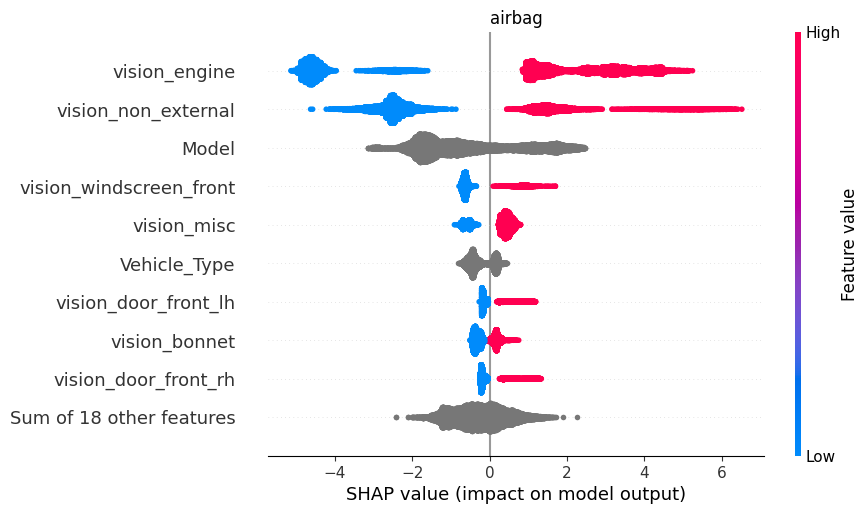

In [832]:
explainer = shap.Explainer(clf)
shap_values = explainer(X_test)
plt.title(targetCol[-1])
shap.plots.beeswarm(shap_values)


In [833]:
caseStudyPred = multilabelPred.sample(n=30).head(30)
caseStudyGt = multilabelGt[multilabelGt["CaseID"].isin(caseStudyPred["CaseID"].unique().tolist())]
caseStudyPred.to_csv("case_study_pred.csv")
caseStudyGt.to_csv("case_study_gt.csv")